# Lecture 3: Image Gradient

## Section 1: Preparation

### Install the libraries

In [34]:
# Import the libraries
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import pyrealsense2 as rs2
import cv2


### Capture an image using realsense camera

In [2]:
pipeline = rs2.pipeline()
config = rs2.config()

config.enable_stream(rs2.stream.color, 1280, 720, rs2.format.bgr8, 30)
config.enable_stream(rs2.stream.depth, 1280, 720, rs2.format.z16, 30)

pipeline.start(config)

# Display the livestream
while True:
    frame = pipeline.wait_for_frames()
    color_frame = frame.get_color_frame()

    color_image = np.asanyarray(color_frame.get_data())

    cv2.imshow("Captured Image", color_image)

    if cv2.waitKey(1) == ord('q'):
        break

cv2.imwrite('photo.jpg', color_image)

cv2.destroyAllWindows()

pipeline.stop()

The captured image


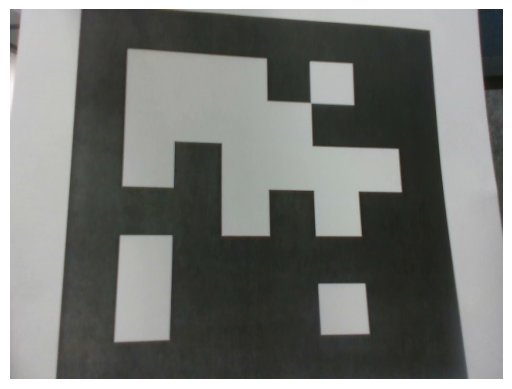

In [35]:
# Load the image
try:
    img = Image.open('photo.jpg')
    img_array = np.array(img)
    # Split the image into RGB channels
    if img_array.shape[-1] != 3: # Check if the image has 3 channels (RGB)
      print("Error: The image does not appear to be an RGB image.")

    print("The captured image")
    plt.axis("off")
    plt.imshow(img_array)


except FileNotFoundError:
    print("Error: The file photo.jpg was not found. Please make sure to capture an image first.")
except Exception as e:
    print(f"An error occurred: {e}")

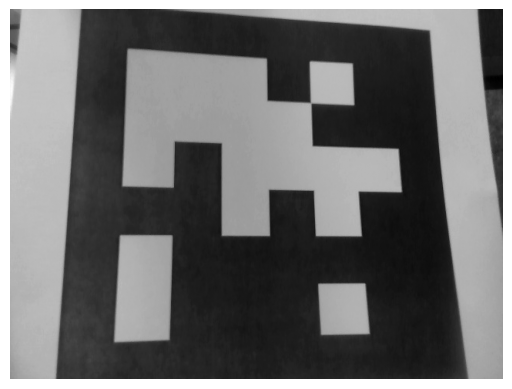

In [36]:
# Convert the image into gray-scale format
img = Image.open('photo.jpg')
# Convert the image to grayscale
img_gray = img.convert('L')

# Convert the grayscale image back to a NumPy array for display
img_gray_array = np.array(img_gray)


plt.axis("off")
plt.imshow(img_gray_array, cmap="gray")
plt.show()


## Section 2: Image graident magnitude & angle

### Recall the image convolution

In [37]:
# Image convolution

def image_correlation(image_array, kernel):
    # Assume a gray-scale image
    assert len(image_array.shape) == 2, "Assume a grayscale image so far"
    H, W = image_array.shape
    kh, kw = kernel.shape
    
    # Correlation
    image_array_processed= np.zeros((H - kh + 1, W - kw + 1))
    for i in range(H - kh + 1):
        for j in range(W - kw + 1):
            image_array_processed[i, j] = np.sum(image_array[i:i+kh, j:j+kw] * kernel)
    return image_array_processed

def image_convolution(image_array, kernel):
    kernel_flipped = np.flip(kernel)
    return image_correlation(image_array, kernel_flipped)

### Blur the image

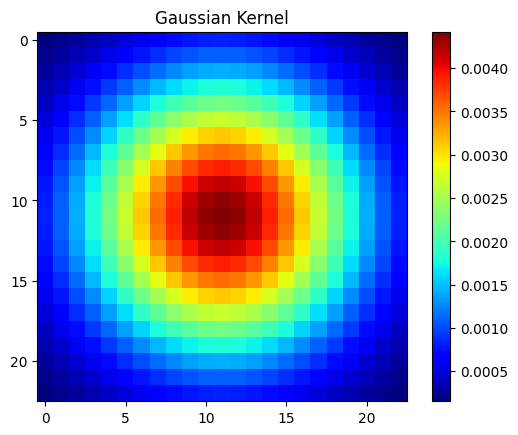

In [38]:
# Define the gaussian kernel
def create_gaussian_kernel(size, sigma=1):
    ax = np.linspace(-(size // 2), size // 2, size)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    return kernel / (2 * np.pi * sigma**2)

kernel_size = 23
sigma = 6
gaussian_kernel = create_gaussian_kernel(kernel_size, sigma)
def visualize_gaussian_kernel(kernel):
    plt.close()
    plt.imshow(kernel, cmap='jet', interpolation='nearest')
    plt.colorbar()
    plt.title('Gaussian Kernel')
    plt.show()
visualize_gaussian_kernel(gaussian_kernel)



Gaussian blurring: 


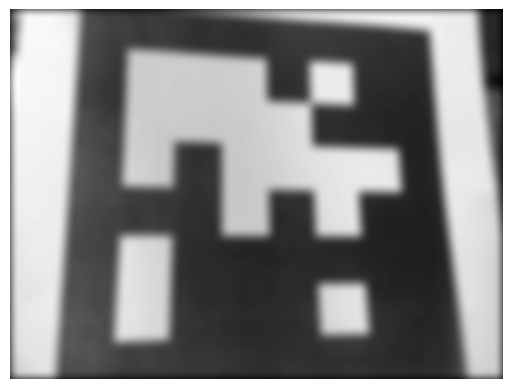

In [39]:
# Display the blurred image (remove noise)
# Padding the image to ensure a constant size
img_gray_array = np.pad(img_gray_array, pad_width=(int)((kernel_size - 1)/2), mode='constant', constant_values=0)

img_gray_array = image_convolution(img_gray_array, gaussian_kernel)
img_gray_array_display = img_gray_array.astype(np.uint8)
print("Gaussian blurring: ")
plt.axis("off")
plt.imshow(img_gray_array_display, cmap="gray")
plt.show()

### Define the Sobel filter

Convolution on Sobel filters


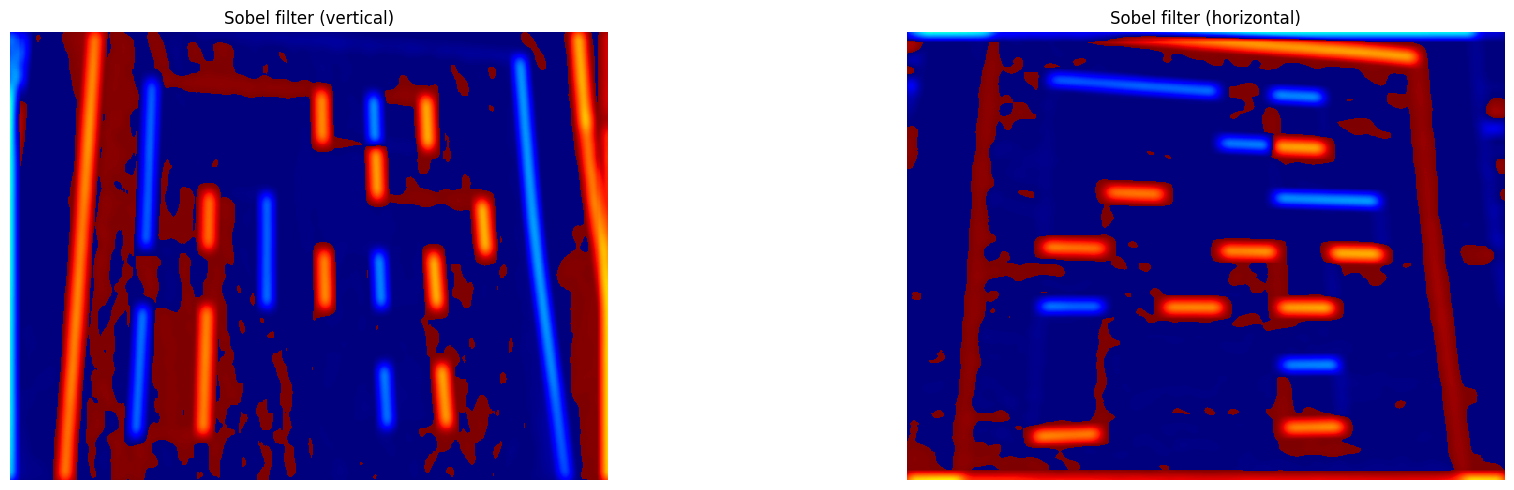

In [40]:
sobel_filter_vertical = np.array([
    [1, 0, -1],
    [2, 0, -2],
    [1, 0, -1]
])
sobel_filter_horizontal = np.array([
    [1, 2, 1],
    [0, 0, 0],
    [-1, -2, -1]
])

img_grad_v = image_convolution(img_gray_array, sobel_filter_vertical)
img_grad_v_display = img_grad_v.astype(np.uint8)


img_grad_h = image_convolution(img_gray_array, sobel_filter_horizontal)
img_grad_h_display = img_grad_h.astype(np.uint8)
# Create a figure and axes for displaying the images
print("Convolution on Sobel filters")
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

# Display the vertical edge detection
axes[0].imshow(img_grad_v_display, cmap='jet', interpolation='nearest')
axes[0].set_title('Sobel filter (vertical)')
axes[0].axis('off')

# Display the horizontal edge detection
axes[1].imshow(img_grad_h_display, cmap='jet', interpolation='nearest')
axes[1].set_title('Sobel filter (horizontal)')
axes[1].axis('off')


plt.tight_layout()
plt.show()


## Image gradient magnitude

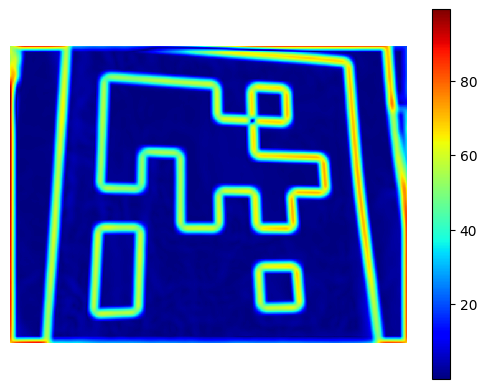

In [41]:
img_grad_mag = np.sqrt(img_grad_v**2 + img_grad_h**2)
plt.axis("off")
plt.imshow(img_grad_mag, cmap='jet', interpolation='nearest')
plt.colorbar()
plt.show()

## Image angle

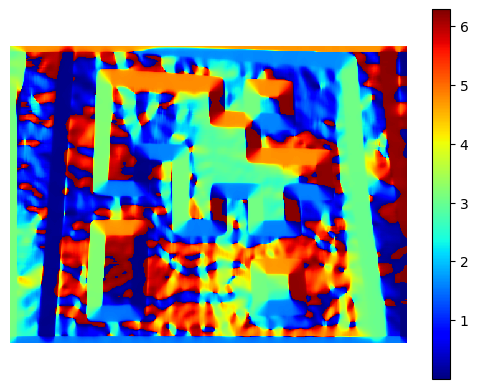

In [42]:
img_angle = np.atan2(img_grad_h, img_grad_v) + np.pi
plt.axis("off")
plt.imshow(img_angle, cmap='jet', interpolation='nearest')
plt.colorbar()
plt.show()

### Angle thresholding the image magnitude

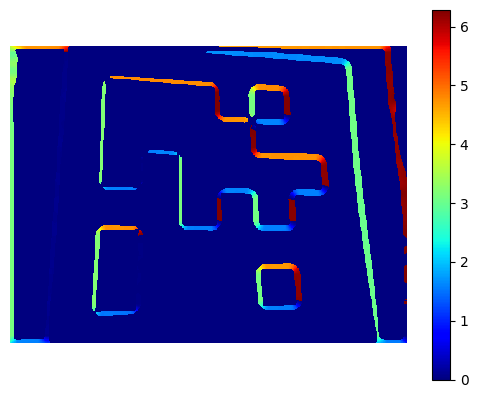

In [43]:
th = 0.5 * np.max(img_grad_mag)
img_angle[img_grad_mag < th] = 0
plt.axis("off")
plt.imshow(img_angle, cmap='jet', interpolation='nearest')
plt.colorbar()
plt.show()

## Image gradients

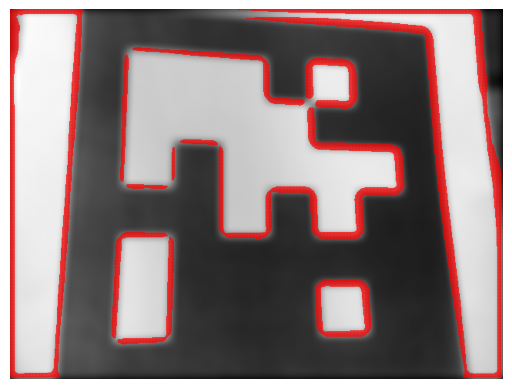

In [33]:
img_grad_x = np.cos(img_angle)
img_grad_x[img_grad_mag < th] = 0
img_grad_y = np.sin(img_angle)
img_grad_y[img_grad_mag < th] = 0
img_grad = np.stack([img_grad_x, img_grad_y], axis=-1)
x_coords = []
y_coords = []
dx = []
dy = []
for i in range(img_grad_x.shape[0]):
    for j in range(img_grad_x.shape[1]):
        if img_grad_x[i][j] != 0:
            x_coords.append(i)
            y_coords.append(j)
            dx.append(img_grad_x[i][j])
            dy.append(img_grad_y[i][j])
%matplotlib inline
plt.axis("off")
plt.imshow(img_gray_array, cmap="gray")
plt.quiver(y_coords, x_coords, dy, dx, color="red")
plt.show()

### OpenCV Implementation (No need to start from scratch!)
Reference: https://stackoverflow.com/questions/51667520/gradient-orientation-in-opencv